In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# File paths
admissions_path = 'ADMISSIONS.csv'
patients_path = 'PATIENTS.csv'
diagnoses_path = 'DIAGNOSES_ICD.csv'
procedures_path = 'PROCEDURES_ICD.csv'
prescriptions_path = 'PRESCRIPTIONS.csv'
labevents_path = 'LABEVENTS.csv'
chartevents_path = 'CHARTEVENTS.csv'

In [ ]:
# Step 1: Readmission index
admissions = pd.read_csv(admissions_path)

# Ensure 'admittime' and 'dischtime' are in datetime format
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])

# Sort by 'subject_id' and 'admittime' to organize admissions chronologically for each patient
admissions = admissions.sort_values(by=['subject_id', 'admittime']).copy()

# Shift 'admittime' and 'subject_id' for the next admission to calculate readmission
admissions['next_admittime'] = admissions.groupby('subject_id')['admittime'].shift(-1)
admissions['next_subject_id'] = admissions.groupby('subject_id')['subject_id'].shift(-1)

# Calculate the time difference between dischtime and the next admission time
admissions['time_diff'] = admissions['next_admittime'] - admissions['dischtime']

# Define readmission within 30 days condition and label as 'yes' or 'no'
admissions['readmitted_within_30_days'] = admissions.apply(
    lambda row: 'yes' if row['time_diff'] <= timedelta(days=30) and row['next_subject_id'] == row['subject_id'] else 'no',
    axis=1
)

# Display the DataFrame to confirm the calculation
admissions[['subject_id', 'admittime', 'dischtime', 'readmitted_within_30_days']].head(10)


,subject_id,admittime,dischtime,readmitted_within_30_days
0,10006,2164-10-23 21:09:00,2164-11-01 17:15:00,no
1,10011,2126-08-14 22:32:00,2126-08-28 18:59:00,no
2,10013,2125-10-04 23:36:00,2125-10-07 15:13:00,no
3,10017,2149-05-26 17:19:00,2149-06-03 18:42:00,no
4,10019,2163-05-14 20:43:00,2163-05-15 12:00:00,no
5,10026,2195-05-17 07:39:00,2195-05-24 11:45:00,no
6,10027,2190-07-13 07:15:00,2190-07-25 14:00:00,no
7,10029,2139-09-22 10:58:00,2139-10-02 14:29:00,no
8,10032,2138-04-02 19:52:00,2138-04-15 14:35:00,no
9,10033,2132-12-05 02:46:00,2132-12-08 15:15:00,no


In [ ]:
# Load admissions data and process readmission as before (assuming admissions is already processed)
patients_df = pd.read_csv(patients_path)
patients_df['dob'] = pd.to_datetime(patients_df['dob'], errors='coerce')

# Filter for valid date range for 'dob'
valid_date_range = (patients_df['dob'] > '1900-01-01') & (patients_df['dob'] < '2100-01-01')
patients_df_filtered = patients_df[valid_date_range][['subject_id', 'gender', 'dob']]

# Merge admissions with patient demographics
merged_data = admissions.merge(patients_df_filtered, on='subject_id', how='left')
merged_data['age_at_admission'] = (merged_data['admittime'] - merged_data['dob']).dt.days / 365.25
merged_data['age_at_admission'] = merged_data['age_at_admission'].round(1)  # Round to 1 decimal place

# Drop 'dob' as it's no longer needed
merged_data = merged_data.drop(columns=['dob'])

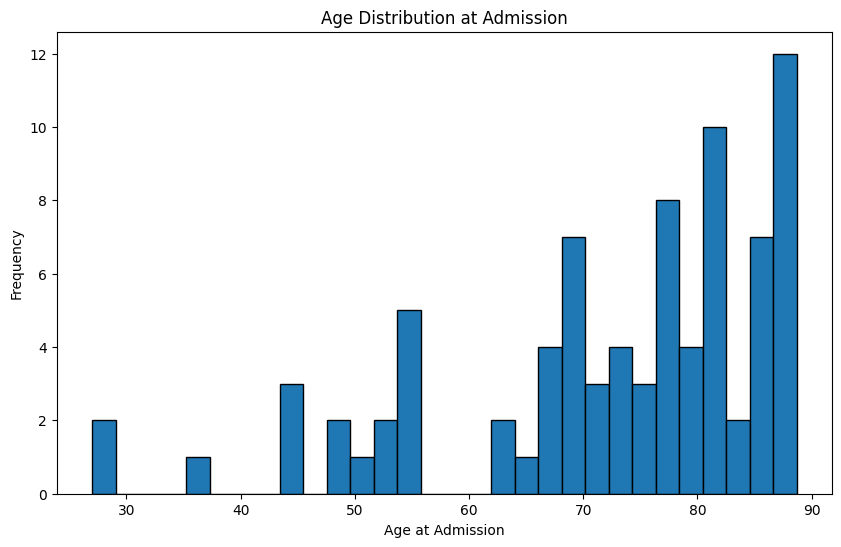

In [ ]:
# Visualization of age range at admission
plt.figure(figsize=(10, 6))
plt.hist(merged_data['age_at_admission'].dropna(), bins=30, edgecolor='black')
plt.title('Age Distribution at Admission')
plt.xlabel('Age at Admission')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Load diagnoses and procedures data
diagnoses_df = pd.read_csv(diagnoses_path)[['subject_id', 'hadm_id', 'icd9_code']].rename(columns={'icd9_code': 'diagnosis_code'})
procedures_df = pd.read_csv(procedures_path)[['subject_id', 'hadm_id', 'icd9_code']].rename(columns={'icd9_code': 'procedure_code'})

# Aggregate diagnosis and procedure codes into lists by 'hadm_id'
diagnoses_agg = diagnoses_df.groupby('hadm_id')['diagnosis_code'].apply(list).reset_index()
procedures_agg = procedures_df.groupby('hadm_id')['procedure_code'].apply(list).reset_index()

# Merge aggregated diagnoses and procedures data with main data
merged_data = merged_data.merge(diagnoses_agg, on='hadm_id', how='left')
merged_data = merged_data.merge(procedures_agg, on='hadm_id', how='left')

# Display a few rows to confirm the merge
merged_data[['subject_id', 'hadm_id', 'diagnosis_code', 'procedure_code']].head(10)

,subject_id,hadm_id,diagnosis_code,procedure_code
0,10006,142345,"[99591, 99662, 5672, 40391, 42731, 4280, 4241,...","[9749, 5491, 3895, 3995, 3893, 9907, 14]"
1,10011,105331,"[570, 07030, 07054, 30401, 2875, 2760]","[9915, 3893]"
2,10013,165520,"[0389, 41071, 78551, 486, 42731, 20280, 4240, ...",[3891]
3,10017,199207,"[81201, 4928, 8028, 8024, 99812, 41511, 2851, ...","[8181, 9904]"
4,10019,177759,"[0389, 51881, 5770, 30390, 5781, 5845, 2848, 5...","[9671, 17, 3995, 9904]"
5,10026,103770,"[431, 4010, 5990, 2761, V103, 3569, 2859]",NaN
6,10027,199395,"[4280, 4240, 3970, 4266, 42731, 5859, 41401, 4...","[3523, 3612, 3961, 8872, 3772, 3783, 9962, 962..."
7,10029,132349,"[0380, 99673, 5761, 57451, 42731, 5856, 4538, ...","[3942, 5110, 9705, 17, 3995, 8721, 8849, 3895]"
8,10032,140372,"[81249, 1985, 5070, 42830, 4280, 2851, 2765, 2...","[7931, 9904, 46, 3893]"
9,10033,157235,"[24220, 51919, 5849, 2767, 42731, E8889, 4019,...",NaN


In [ ]:
# Load prescriptions data and select relevant columns
prescriptions_df = pd.read_csv(prescriptions_path, usecols=['subject_id', 'hadm_id', 'drug'])

# Aggregate medications by 'hadm_id' into lists
medications_agg = prescriptions_df.groupby('hadm_id')['drug'].apply(list).reset_index()

# Merge aggregated medications with main data on 'hadm_id'
merged_data = merged_data.merge(medications_agg, on='hadm_id', how='left')

# Fill missing values in 'drug' and 'procedure_code' with empty lists
merged_data['procedure_code'] = merged_data['procedure_code'].apply(lambda x: x if isinstance(x, list) else [])
merged_data['drug'] = merged_data['drug'].apply(lambda x: x if isinstance(x, list) else [])

# Display a few rows to confirm the merge
print(merged_data[['subject_id', 'hadm_id', 'diagnosis_code', 'procedure_code', 'drug']].head(10))

   subject_id  hadm_id                                     diagnosis_code  \
0       10006   142345  [99591, 99662, 5672, 40391, 42731, 4280, 4241,...   
1       10011   105331             [570, 07030, 07054, 30401, 2875, 2760]   
2       10013   165520  [0389, 41071, 78551, 486, 42731, 20280, 4240, ...   
3       10017   199207  [81201, 4928, 8028, 8024, 99812, 41511, 2851, ...   
4       10019   177759  [0389, 51881, 5770, 30390, 5781, 5845, 2848, 5...   
5       10026   103770          [431, 4010, 5990, 2761, V103, 3569, 2859]   
6       10027   199395  [4280, 4240, 3970, 4266, 42731, 5859, 41401, 4...   
7       10029   132349  [0380, 99673, 5761, 57451, 42731, 5856, 4538, ...   
8       10032   140372  [81249, 1985, 5070, 42830, 4280, 2851, 2765, 2...   
9       10033   157235  [24220, 51919, 5849, 2767, 42731, E8889, 4019,...   

                                      procedure_code  \
0           [9749, 5491, 3895, 3995, 3893, 9907, 14]   
1                                       

In [ ]:
# Load required columns from LABEVENTS and CHARTEVENTS (assuming large data)
labevents_df = pd.read_csv(labevents_path, usecols=['subject_id', 'hadm_id', 'itemid', 'valuenum'])
chartevents_df = pd.read_csv(chartevents_path, usecols=['subject_id', 'hadm_id', 'itemid', 'valuenum'])

# Define important item IDs for labs and vitals
important_lab_items = [50868, 50882, 50902, 50912]  # Replace with actual important lab item IDs
important_vital_items = [223762, 220045, 220179, 224690]  # Replace with actual important vital item IDs

# Filter rows based on important item IDs
labevents_df = labevents_df[labevents_df['itemid'].isin(important_lab_items)]
chartevents_df = chartevents_df[chartevents_df['itemid'].isin(important_vital_items)]

# Aggregate by mean and last value per item for each admission in LABEVENTS and CHARTEVENTS
labevents_agg = labevents_df.groupby(['hadm_id', 'itemid']).agg(
    lab_mean=('valuenum', 'mean'), lab_last=('valuenum', 'last')).unstack().reset_index()
chartevents_agg = chartevents_df.groupby(['hadm_id', 'itemid']).agg(
    vital_mean=('valuenum', 'mean'), vital_last=('valuenum', 'last')).unstack().reset_index()

# Flatten multi-level columns
labevents_agg.columns = ['hadm_id' if col[0] == 'hadm_id' else f"{col[0]}_{col[1]}" for col in labevents_agg.columns]
chartevents_agg.columns = ['hadm_id' if col[0] == 'hadm_id' else f"{col[0]}_{col[1]}" for col in chartevents_agg.columns]

# Merge the aggregated lab and vital data with the main dataset
merged_data = merged_data.merge(labevents_agg, on='hadm_id', how='left')
merged_data = merged_data.merge(chartevents_agg, on='hadm_id', how='left')

# Display the first few rows of the final merged dataset to confirm
print(merged_data.head())

   row_id  subject_id  hadm_id           admittime           dischtime  \
0   12258       10006   142345 2164-10-23 21:09:00 2164-11-01 17:15:00   
1   12263       10011   105331 2126-08-14 22:32:00 2126-08-28 18:59:00   
2   12265       10013   165520 2125-10-04 23:36:00 2125-10-07 15:13:00   
3   12269       10017   199207 2149-05-26 17:19:00 2149-06-03 18:42:00   
4   12270       10019   177759 2163-05-14 20:43:00 2163-05-15 12:00:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

  discharge_location insurance  ... lab_last_50902 lab_last_50912  \
0   HOME HEALTH CARE  Medicare  ...          104.0            3.7   
1       

In [ ]:
merged_data.isnull().sum()

,0
row_id,0
subject_id,0
hadm_id,0
admittime,0
dischtime,0
deathtime,89
admission_type,0
admission_location,0
discharge_location,0
insurance,0


# **DATA CLEANING**

In [ ]:
for col in merged_data.columns:
    if 'lab_' in col or 'vital_' in col:
        merged_data[col].fillna(merged_data[col].median(), inplace=True)

# Alternatively, add binary indicators for missing data
for col in merged_data.columns:
    if 'lab_' in col or 'vital_' in col:
        merged_data[f'{col}_missing'] = merged_data[col].isnull().astype(int)

<ipython-input-10-f2d12f8826a2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(merged_data[col].median(), inplace=True)


In [ ]:
merged_data.isnull().sum()

,0
row_id,0
subject_id,0
hadm_id,0
admittime,0
dischtime,0
deathtime,89
admission_type,0
admission_location,0
discharge_location,0
insurance,0


In [ ]:
# Impute categorical fields with "unknown"
merged_data['marital_status'].fillna("unknown", inplace=True)

<ipython-input-12-dc4878781d74>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['marital_status'].fillna("unknown", inplace=True)


In [ ]:
# Impute numerical fields with the median
merged_data['age_at_admission'].fillna(merged_data['age_at_admission'].median(), inplace=True)

<ipython-input-13-ea9b2bdbc125>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['age_at_admission'].fillna(merged_data['age_at_admission'].median(), inplace=True)


In [ ]:
# Convert 'admittime' and 'dischtime' to datetime
merged_data['admittime'] = pd.to_datetime(merged_data['admittime'], errors='coerce')
merged_data['dischtime'] = pd.to_datetime(merged_data['dischtime'], errors='coerce')

# Calculate Length of Stay (LOS) in days and handle same-day discharges
merged_data['length_of_stay_days'] = (
    merged_data['dischtime'] - merged_data['admittime']
).dt.total_seconds() / (24 * 3600)

# Set minimum LOS of 1 day for same-day admissions and discharges
merged_data['length_of_stay_days'] = merged_data['length_of_stay_days'].apply(lambda x: 1 if x < 1 else round(x))

# Display summary statistics for LOS in days
print("Length of Stay (Days) Summary:")
print(merged_data['length_of_stay_days'].describe())

Length of Stay (Days) Summary:
count    129.000000
mean       9.387597
std       12.692462
min        1.000000
25%        3.000000
50%        7.000000
75%       11.000000
max      124.000000
Name: length_of_stay_days, dtype: float64


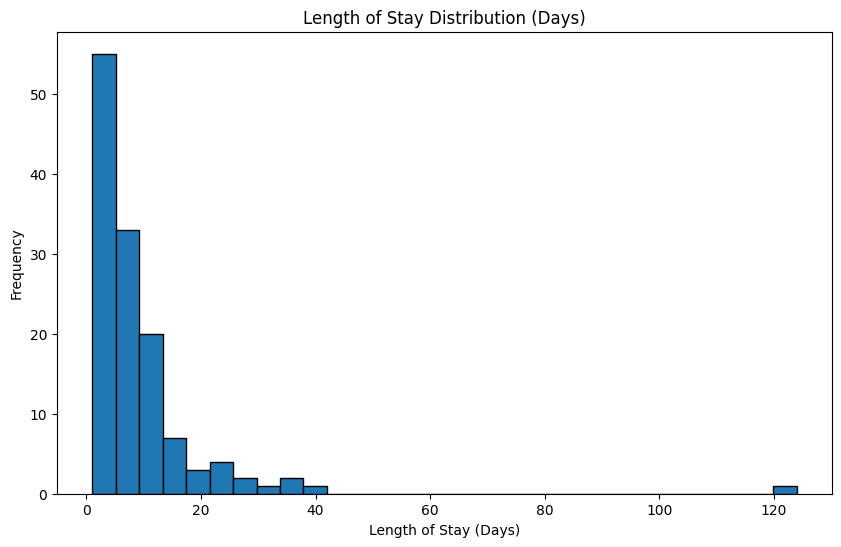

In [ ]:
# Visualize the distribution of LOS in days
plt.figure(figsize=(10, 6))
plt.hist(merged_data['length_of_stay_days'].dropna(), bins=30, edgecolor='black')
plt.title("Length of Stay Distribution (Days)")
plt.xlabel("Length of Stay (Days)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Count Number of Prior Admissions for each patient
merged_data['prior_admissions'] = merged_data.groupby('subject_id').cumcount()

In [ ]:
merged_data.isnull().sum()

,0
row_id,0
subject_id,0
hadm_id,0
admittime,0
dischtime,0
...,...
vital_last_220179_missing,0
vital_last_223762_missing,0
vital_last_224690_missing,0
length_of_stay_days,0


In [ ]:
# Fill missing values in categorical fields with "unknown"
merged_data['gender'].fillna("unknown", inplace=True)

<ipython-input-18-30e2842d78a8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['gender'].fillna("unknown", inplace=True)


In [ ]:
# Convert 'edregtime' and 'edouttime' to datetime, handling any non-date placeholders (e.g., "unknown")
merged_data['edregtime'] = pd.to_datetime(merged_data['edregtime'], errors='coerce')
merged_data['edouttime'] = pd.to_datetime(merged_data['edouttime'], errors='coerce')

# Calculate the duration in the emergency ward in hours
merged_data['emergency_duration_hours'] = (merged_data['edouttime'] - merged_data['edregtime']).dt.total_seconds() / 3600

# Display sample data to verify
print(merged_data[['subject_id', 'hadm_id', 'edregtime', 'edouttime', 'emergency_duration_hours']].head())


   subject_id  hadm_id           edregtime           edouttime  \
0       10006   142345 2164-10-23 16:43:00 2164-10-23 23:00:00   
1       10011   105331                 NaT                 NaT   
2       10013   165520                 NaT                 NaT   
3       10017   199207 2149-05-26 12:08:00 2149-05-26 19:45:00   
4       10019   177759                 NaT                 NaT   

   emergency_duration_hours  
0                  6.283333  
1                       NaN  
2                       NaN  
3                  7.616667  
4                       NaN  


In [ ]:
# Replace NaN values in 'emergency_duration_hours' with 0
merged_data['emergency_duration_hours'].fillna(0, inplace=True)

<ipython-input-20-3d8b4e0acf5d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['emergency_duration_hours'].fillna(0, inplace=True)


In [ ]:
# Drop all columns with '_missing' in their names
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains('_missing')]

# Display the first few rows to confirm removal
print(merged_data.head())

   row_id  subject_id  hadm_id           admittime           dischtime  \
0   12258       10006   142345 2164-10-23 21:09:00 2164-11-01 17:15:00   
1   12263       10011   105331 2126-08-14 22:32:00 2126-08-28 18:59:00   
2   12265       10013   165520 2125-10-04 23:36:00 2125-10-07 15:13:00   
3   12269       10017   199207 2149-05-26 17:19:00 2149-06-03 18:42:00   
4   12270       10019   177759 2163-05-14 20:43:00 2163-05-15 12:00:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

  discharge_location insurance  ... vital_mean_220179 vital_mean_223762  \
0   HOME HEALTH CARE  Medicare  ...        117.767687         37.443333

In [ ]:
# Convert 'has_chartevents_data' to "yes" and "no" instead of 1 and 0
merged_data['has_chartevents_data'] = merged_data['has_chartevents_data'].apply(lambda x: 'yes' if x == 1 else 'no')

# Verify conversion
has_chartevents_data_unique = merged_data['has_chartevents_data'].unique()
print(has_chartevents_data_unique)

['yes' 'no']


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   row_id                     129 non-null    int64          
 1   subject_id                 129 non-null    int64          
 2   hadm_id                    129 non-null    int64          
 3   admittime                  129 non-null    datetime64[ns] 
 4   dischtime                  129 non-null    datetime64[ns] 
 5   deathtime                  40 non-null     object         
 6   admission_type             129 non-null    object         
 7   admission_location         129 non-null    object         
 8   discharge_location         129 non-null    object         
 9   insurance                  129 non-null    object         
 10  language                   81 non-null     object         
 11  religion                   128 non-null    object         

In [ ]:
# Function to count unique medications, assuming 'drug' is a list
def count_unique_medications(drug_list):
    if isinstance(drug_list, list):
        # Count unique medications in the list
        return len(set(drug_list))
    return 0  # Return 0 if drug_list is not a list (though it should be)

# Apply the function to count unique medications in 'drug' column of merged_data
merged_data['medication_count'] = merged_data['drug'].apply(count_unique_medications)

# Display unique values in `medication_count` to verify the range
print(merged_data['medication_count'].unique())

[ 34   0  20  52  32  26  45  30  21  18  35  42  40  74  19  69   9  31
  51  48  25  27  17  47  41  43  22  28  73  76  62  38  44  24 143  55
  36  54  29  14  57  56  16  68  33   8  58  23  13  70  15]


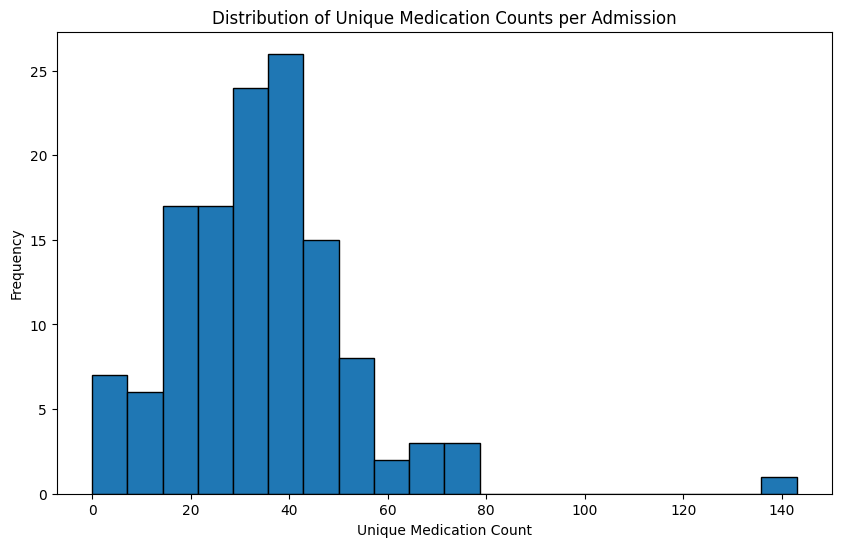

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of medication counts
plt.figure(figsize=(10, 6))
plt.hist(merged_data['medication_count'], bins=20, edgecolor='black')
plt.title("Distribution of Unique Medication Counts per Admission")
plt.xlabel("Unique Medication Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Convert all text columns to lowercase for consistency
text_columns = merged_data.select_dtypes(include='object').columns

# Apply the lowercase transformation
merged_data[text_columns] = merged_data[text_columns].apply(lambda x: x.str.lower())

# Display the first few rows to verify the text conversion
merged_data.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,vital_mean_223762,vital_mean_224690,vital_last_220045,vital_last_220179,vital_last_223762,vital_last_224690,length_of_stay_days,prior_admissions,emergency_duration_hours,medication_count
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,emergency,emergency room admit,home health care,medicare,...,37.443333,20.0,79.5,115.0,36.3,18.0,9,0,6.283333,34
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,emergency,transfer from hosp/extram,dead/expired,private,...,37.443333,20.0,79.5,115.0,36.3,18.0,14,0,0.000000,0
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,emergency,transfer from hosp/extram,dead/expired,medicare,...,37.443333,20.0,79.5,115.0,36.3,18.0,3,0,0.000000,20
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,emergency,emergency room admit,snf,medicare,...,37.443333,20.0,79.5,115.0,36.3,18.0,8,0,7.616667,52
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,emergency,transfer from hosp/extram,dead/expired,medicare,...,37.443333,20.0,79.5,115.0,36.3,18.0,1,0,0.000000,32


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   row_id                     129 non-null    int64          
 1   subject_id                 129 non-null    int64          
 2   hadm_id                    129 non-null    int64          
 3   admittime                  129 non-null    datetime64[ns] 
 4   dischtime                  129 non-null    datetime64[ns] 
 5   deathtime                  40 non-null     object         
 6   admission_type             129 non-null    object         
 7   admission_location         129 non-null    object         
 8   discharge_location         129 non-null    object         
 9   insurance                  129 non-null    object         
 10  language                   81 non-null     object         
 11  religion                   128 non-null    object         

In [ ]:
merged_data.drop(columns=['next_admittime', 'next_subject_id', 'time_diff', 'row_id',
                          'deathtime', 'hospital_expire_flag', 'religion', 'language',
                          'admittime', 'dischtime','edregtime', 'edouttime', 'ethnicity', 'drug'], inplace=True)

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 129 non-null    int64  
 1   hadm_id                    129 non-null    int64  
 2   admission_type             129 non-null    object 
 3   admission_location         129 non-null    object 
 4   discharge_location         129 non-null    object 
 5   insurance                  129 non-null    object 
 6   marital_status             129 non-null    object 
 7   diagnosis                  129 non-null    object 
 8   has_chartevents_data       129 non-null    object 
 9   readmitted_within_30_days  129 non-null    object 
 10  gender                     129 non-null    object 
 11  age_at_admission           129 non-null    float64
 12  diagnosis_code             0 non-null      float64
 13  procedure_code             0 non-null      float64

In [ ]:
merged_data.prior_admissions.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
merged_data.drop(columns=['diagnosis_code', 'procedure_code'], inplace=True)


Outliers in subject_id:
Series([], Name: subject_id, dtype: int64)
Number of outliers in subject_id: 0

Outliers in hadm_id:
Series([], Name: hadm_id, dtype: int64)
Number of outliers in hadm_id: 0

Outliers in age_at_admission:
1      36.2
34     27.9
50     27.0
73     48.9
74     49.1
75     55.0
93     50.6
95     43.8
96     44.0
117    55.1
118    53.5
119    53.6
122    54.5
123    54.5
124    54.5
126    45.4
Name: age_at_admission, dtype: float64
Number of outliers in age_at_admission: 16

Outliers in lab_mean_50868:
4     34.000000
23    20.000000
25    32.000000
35    19.750000
50    37.083333
67    19.000000
77     7.800000
96    26.647059
Name: lab_mean_50868, dtype: float64
Number of outliers in lab_mean_50868: 8

Outliers in lab_mean_50882:
4      14.000000
25     10.000000
35     15.250000
73     40.916667
74     40.500000
96     12.800000
104    40.125000
105    36.500000
120    42.000000
Name: lab_mean_50882, dtype: float64
Number of outliers in lab_mean_50882: 9

Ou

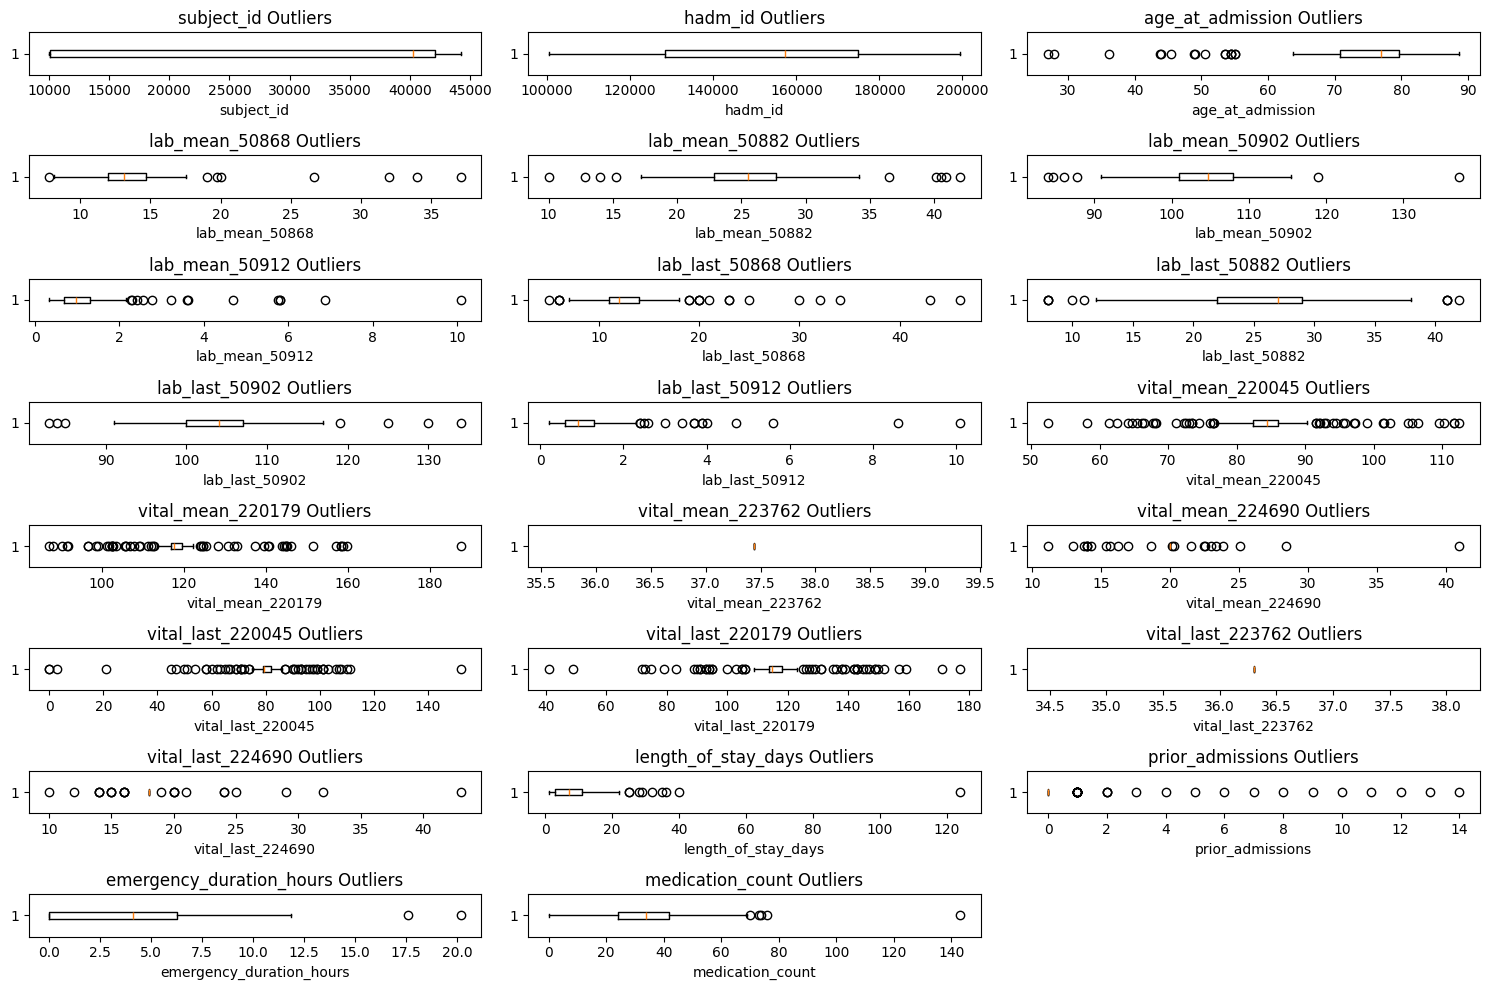

In [ ]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Loop through all numeric columns to detect and display outliers
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    outliers = detect_outliers_iqr(merged_data[col])
    print(f"\nOutliers in {col}:")
    print(outliers)
    print(f"Number of outliers in {col}: {len(outliers)}")

# Visualize using boxplots for all numeric columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  # Adjust layout for subplots
    plt.boxplot(merged_data[col].dropna(), vert=False)
    plt.title(f"{col} Outliers")
    plt.xlabel(col)
plt.tight_layout()
plt.show()


Summary statistics for age_at_admission:
count    129.000000
mean      73.909302
std       11.901900
min       27.000000
25%       70.800000
50%       76.900000
75%       79.600000
max       88.700000
Name: age_at_admission, dtype: float64


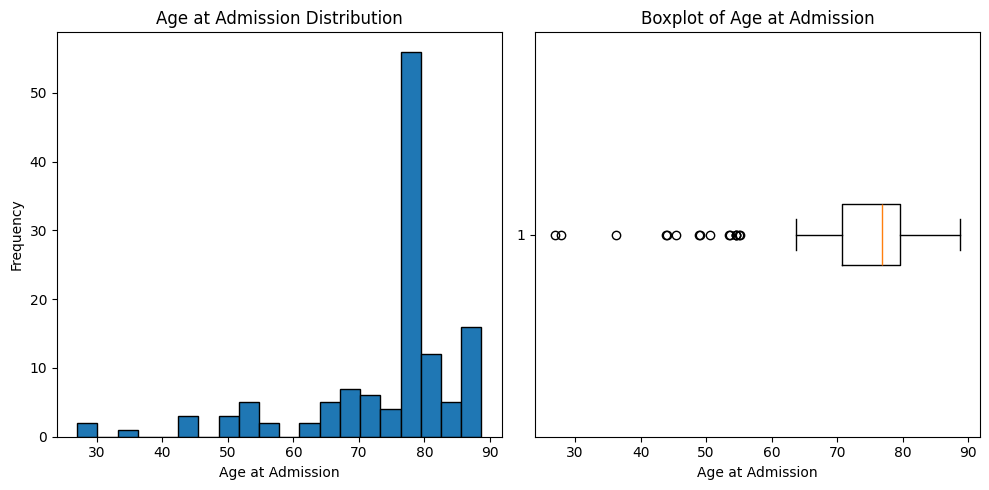

In [ ]:
# Summary statistics for age_at_admission
print("Summary statistics for age_at_admission:")
print(merged_data['age_at_admission'].describe())

# Visualize age distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(merged_data['age_at_admission'].dropna(), bins=20, edgecolor='black')
plt.title("Age at Admission Distribution")
plt.xlabel("Age at Admission")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(merged_data['age_at_admission'].dropna(), vert=False)
plt.title("Boxplot of Age at Admission")
plt.xlabel("Age at Admission")

plt.tight_layout()
plt.show()


In [ ]:
# Define length of stay categories with concise labels
def categorize_length_of_stay(days):
    if days <= 3:
        return f"short stay of {days} days"
    elif days <= 7:
        return f"medium stay of {days} days"
    elif days <= 30:
        return f"long stay of {days} days"
    else:
        return f"very long stay of {days} days"

# Apply the categorization to create the stay description
merged_data['length_of_stay_label'] = merged_data['length_of_stay_days'].apply(categorize_length_of_stay)

# Display a few examples to verify
print(merged_data[['subject_id', 'hadm_id', 'length_of_stay_days', 'length_of_stay_label']].head(10))

   subject_id  hadm_id  length_of_stay_days   length_of_stay_label
0       10006   142345                    9    long stay of 9 days
1       10011   105331                   14   long stay of 14 days
2       10013   165520                    3   short stay of 3 days
3       10017   199207                    8    long stay of 8 days
4       10019   177759                    1   short stay of 1 days
5       10026   103770                    7  medium stay of 7 days
6       10027   199395                   12   long stay of 12 days
7       10029   132349                   10   long stay of 10 days
8       10032   140372                   13   long stay of 13 days
9       10033   157235                    4  medium stay of 4 days


In [ ]:
# Step 1: Cap medication count at the 95th percentile or a chosen threshold
cap_value = merged_data['medication_count'].quantile(0.95)
merged_data['capped_medication_count'] = merged_data['medication_count'].apply(lambda x: min(x, cap_value))

# Step 2: Define medication diversity categories based on the capped values
def categorize_medication_count(count):
    if count < 30:
        return f"low medication diversity of {int(count)} unique medications"
    elif count < 50:
        return f"moderate medication diversity of {int(count)} unique medications"
    elif count < 100:
        return f"high medication diversity of {int(count)} unique medications"
    else:
        return f"very high medication diversity of {int(count)} unique medications"

# Step 3: Apply the categorization function to create a descriptive label
merged_data['medication_diversity_label'] = merged_data['capped_medication_count'].apply(categorize_medication_count)

# Display a few examples to verify
print(merged_data[['subject_id', 'hadm_id', 'medication_count', 'capped_medication_count', 'medication_diversity_label']].head(10))

   subject_id  hadm_id  medication_count  capped_medication_count  \
0       10006   142345                34                     34.0   
1       10011   105331                 0                      0.0   
2       10013   165520                20                     20.0   
3       10017   199207                52                     52.0   
4       10019   177759                32                     32.0   
5       10026   103770                26                     26.0   
6       10027   199395                45                     45.0   
7       10029   132349                32                     32.0   
8       10032   140372                30                     30.0   
9       10033   157235                21                     21.0   

                          medication_diversity_label  
0  moderate medication diversity of 34 unique med...  
1   low medication diversity of 0 unique medications  
2  low medication diversity of 20 unique medications  
3  high medication d

In [ ]:
# Cap emergency_duration_hours at the 95th percentile
cap_value = merged_data['emergency_duration_hours'].quantile(0.95)
merged_data['capped_emergency_duration'] = merged_data['emergency_duration_hours'].apply(lambda x: min(x, cap_value))

In [ ]:
# Define categories for emergency duration
def categorize_emergency_duration(hours):
    if hours <= 4:
        return f"short duration of {hours} hours"
    elif hours <= 8:
        return f"moderate duration of {hours} hours"
    elif hours <= 12:
        return f"long duration of {hours} hours"
    else:
        return f"extended duration of {hours} hours"

# Apply the categorization to the capped emergency duration
merged_data['emergency_duration_label'] = merged_data['capped_emergency_duration'].apply(categorize_emergency_duration)


In [ ]:
# Display a few examples to verify
print(merged_data[['subject_id', 'hadm_id', 'emergency_duration_label']].head(10))

   subject_id  hadm_id                      emergency_duration_label
0       10006   142345  moderate duration of 6.283333333333333 hours
1       10011   105331                   short duration of 0.0 hours
2       10013   165520                   short duration of 0.0 hours
3       10017   199207  moderate duration of 7.616666666666666 hours
4       10019   177759                   short duration of 0.0 hours
5       10026   103770  moderate duration of 6.666666666666667 hours
6       10027   199395                   short duration of 0.0 hours
7       10029   132349  moderate duration of 5.783333333333333 hours
8       10032   140372  moderate duration of 5.733333333333333 hours
9       10033   157235                moderate duration of 7.9 hours


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  129 non-null    int64  
 1   hadm_id                     129 non-null    int64  
 2   admission_type              129 non-null    object 
 3   admission_location          129 non-null    object 
 4   discharge_location          129 non-null    object 
 5   insurance                   129 non-null    object 
 6   marital_status              129 non-null    object 
 7   diagnosis                   129 non-null    object 
 8   has_chartevents_data        129 non-null    object 
 9   readmitted_within_30_days   129 non-null    object 
 10  gender                      129 non-null    object 
 11  age_at_admission            129 non-null    float64
 12  lab_mean_50868              129 non-null    float64
 13  lab_mean_50882              129 non

In [ ]:
# Drop specific columns
merged_data = merged_data.drop(columns=['capped_medication_count', 'capped_emergency_duration', 'length_of_stay_days', 'medication_count'])

# Display the remaining columns to verify the removal
print(merged_data.columns)


Index(['subject_id', 'hadm_id', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'marital_status', 'diagnosis',
       'has_chartevents_data', 'readmitted_within_30_days', 'gender',
       'age_at_admission', 'lab_mean_50868', 'lab_mean_50882',
       'lab_mean_50902', 'lab_mean_50912', 'lab_last_50868', 'lab_last_50882',
       'lab_last_50902', 'lab_last_50912', 'vital_mean_220045',
       'vital_mean_220179', 'vital_mean_223762', 'vital_mean_224690',
       'vital_last_220045', 'vital_last_220179', 'vital_last_223762',
       'vital_last_224690', 'prior_admissions', 'emergency_duration_hours',
       'length_of_stay_label', 'medication_diversity_label',
       'emergency_duration_label'],
      dtype='object')


In [ ]:
# Drop specific columns
merged_data = merged_data.drop(columns=['emergency_duration_hours'])

# Display the remaining columns to verify the removal
print(merged_data.columns)

Index(['subject_id', 'hadm_id', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'marital_status', 'diagnosis',
       'has_chartevents_data', 'readmitted_within_30_days', 'gender',
       'age_at_admission', 'lab_mean_50868', 'lab_mean_50882',
       'lab_mean_50902', 'lab_mean_50912', 'lab_last_50868', 'lab_last_50882',
       'lab_last_50902', 'lab_last_50912', 'vital_mean_220045',
       'vital_mean_220179', 'vital_mean_223762', 'vital_mean_224690',
       'vital_last_220045', 'vital_last_220179', 'vital_last_223762',
       'vital_last_224690', 'prior_admissions', 'length_of_stay_label',
       'medication_diversity_label', 'emergency_duration_label'],
      dtype='object')


In [ ]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Loop through all numeric columns to detect and display outliers
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    outliers = detect_outliers_iqr(merged_data[col])
    print(f"\nOutliers in {col}:")
    print(outliers)
    print(f"Number of outliers in {col}: {len(outliers)}")


Outliers in subject_id:
Series([], Name: subject_id, dtype: int64)
Number of outliers in subject_id: 0

Outliers in hadm_id:
Series([], Name: hadm_id, dtype: int64)
Number of outliers in hadm_id: 0

Outliers in age_at_admission:
1      36.2
34     27.9
50     27.0
73     48.9
74     49.1
75     55.0
93     50.6
95     43.8
96     44.0
117    55.1
118    53.5
119    53.6
122    54.5
123    54.5
124    54.5
126    45.4
Name: age_at_admission, dtype: float64
Number of outliers in age_at_admission: 16

Outliers in lab_mean_50868:
4     34.000000
23    20.000000
25    32.000000
35    19.750000
50    37.083333
67    19.000000
77     7.800000
96    26.647059
Name: lab_mean_50868, dtype: float64
Number of outliers in lab_mean_50868: 8

Outliers in lab_mean_50882:
4      14.000000
25     10.000000
35     15.250000
73     40.916667
74     40.500000
96     12.800000
104    40.125000
105    36.500000
120    42.000000
Name: lab_mean_50882, dtype: float64
Number of outliers in lab_mean_50882: 9

Ou

In [ ]:
merged_data.shape

(129, 32)

In [ ]:
# Separate the majority and minority classes based on 'yes' and 'no' values
majority_class = merged_data[merged_data['readmitted_within_30_days'] == 'no']
minority_class = merged_data[merged_data['readmitted_within_30_days'] == 'yes']

# Oversample the minority class to match the majority class size
minority_oversampled = minority_class.sample(len(majority_class), replace=True, random_state=42)

# Combine the oversampled minority class with the majority class
balance = pd.concat([majority_class, minority_oversampled], axis=0).reset_index(drop=True)

# Check the new balance of the target variable
balanced_counts = balance['readmitted_within_30_days'].value_counts()
print("Balanced class distribution:\n", balanced_counts)

Balanced class distribution:
 readmitted_within_30_days
no     118
yes    118
Name: count, dtype: int64


In [ ]:
# Check if the oversampled minority class contains only original rows from the minority class
# Create a set of original row indices for minority class
original_indices = set(minority_class.index)
duplicated_indices = set(minority_oversampled.index)

# Verify if all rows in minority_oversampled are part of original minority class
is_balanced_correctly = duplicated_indices.issubset(original_indices)

# Display the result
print("Is the balancing done correctly without altering original rows?", is_balanced_correctly)

Is the balancing done correctly without altering original rows? True


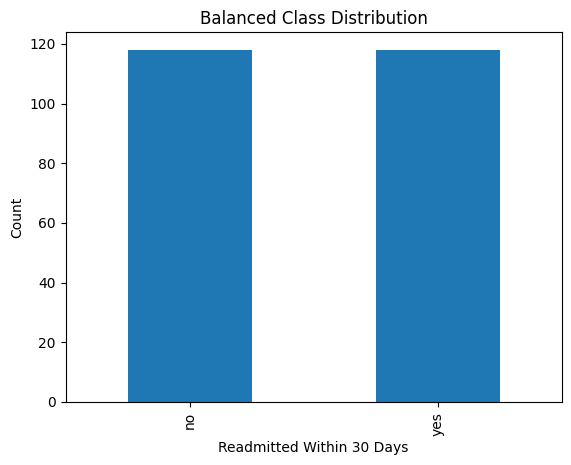

In [ ]:
import matplotlib.pyplot as plt

# Plot the balanced class distribution
balance['readmitted_within_30_days'].value_counts().plot(kind='bar')
plt.xlabel("Readmitted Within 30 Days")
plt.ylabel("Count")
plt.title("Balanced Class Distribution")
plt.show()

In [ ]:
balance.shape

(236, 32)

In [ ]:
# Remove ".0" suffix from column names if present
balance.columns = [col.replace(".0", "") if ".0" in col else col for col in balanced_data.columns]

# Display the updated column names to confirm changes
print(balance.columns.tolist())

['subject_id', 'hadm_id', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'diagnosis', 'has_chartevents_data', 'readmitted_within_30_days', 'gender', 'age_at_admission', 'lab_mean_50868', 'lab_mean_50882', 'lab_mean_50902', 'lab_mean_50912', 'lab_last_50868', 'lab_last_50882', 'lab_last_50902', 'lab_last_50912', 'vital_mean_220045', 'vital_mean_220179', 'vital_mean_223762', 'vital_mean_224690', 'vital_last_220045', 'vital_last_220179', 'vital_last_223762', 'vital_last_224690', 'prior_admissions', 'length_of_stay_label', 'medication_diversity_label', 'emergency_duration_label']


In [ ]:
balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  236 non-null    int64  
 1   hadm_id                     236 non-null    int64  
 2   admission_type              236 non-null    object 
 3   admission_location          236 non-null    object 
 4   discharge_location          236 non-null    object 
 5   insurance                   236 non-null    object 
 6   marital_status              236 non-null    object 
 7   diagnosis                   236 non-null    object 
 8   has_chartevents_data        236 non-null    object 
 9   readmitted_within_30_days   236 non-null    object 
 10  gender                      236 non-null    object 
 11  age_at_admission            236 non-null    float64
 12  lab_mean_50868              236 non-null    float64
 13  lab_mean_50882              236 non

In [ ]:
# Replace 'f' with 'female' and 'm' with 'male' in the gender column
balance['gender'] = balance['gender'].replace({'f': 'female', 'm': 'male'})

# Verify the changes
print(balance['gender'].value_counts())

gender
male       96
unknown    84
female     56
Name: count, dtype: int64


In [ ]:
balance.head(10)

,subject_id,hadm_id,admission_type,admission_location,discharge_location,insurance,marital_status,diagnosis,has_chartevents_data,readmitted_within_30_days,...,vital_mean_223762,vital_mean_224690,vital_last_220045,vital_last_220179,vital_last_223762,vital_last_224690,prior_admissions,length_of_stay_label,medication_diversity_label,emergency_duration_label
0,10006,142345,emergency,emergency room admit,home health care,medicare,separated,sepsis,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,long stay of 9 days,moderate medication diversity of 34 unique med...,moderate duration of 6.283333333333333 hours
1,10011,105331,emergency,transfer from hosp/extram,dead/expired,private,single,hepatitis b,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,long stay of 14 days,low medication diversity of 0 unique medications,short duration of 0.0 hours
2,10013,165520,emergency,transfer from hosp/extram,dead/expired,medicare,unknown,sepsis,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,short stay of 3 days,low medication diversity of 20 unique medications,short duration of 0.0 hours
3,10017,199207,emergency,emergency room admit,snf,medicare,divorced,humeral fracture,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,long stay of 8 days,high medication diversity of 52 unique medicat...,moderate duration of 7.616666666666666 hours
4,10019,177759,emergency,transfer from hosp/extram,dead/expired,medicare,divorced,alcoholic hepatitis,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,short stay of 1 days,moderate medication diversity of 32 unique med...,short duration of 0.0 hours
5,10026,103770,emergency,emergency room admit,rehab/distinct part hosp,medicare,unknown,stroke/tia,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,medium stay of 7 days,low medication diversity of 26 unique medications,moderate duration of 6.666666666666667 hours
6,10027,199395,elective,phys referral/normal deli,snf,medicare,married,mitral regurgitation;coronary artery disease\...,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,long stay of 12 days,moderate medication diversity of 45 unique med...,short duration of 0.0 hours
7,10029,132349,emergency,emergency room admit,snf,medicare,divorced,syncope;telemetry,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,long stay of 10 days,moderate medication diversity of 32 unique med...,moderate duration of 5.783333333333333 hours
8,10032,140372,emergency,emergency room admit,rehab/distinct part hosp,medicare,widowed,right humerous fracture,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,long stay of 13 days,moderate medication diversity of 30 unique med...,moderate duration of 5.733333333333333 hours
9,10033,157235,emergency,emergency room admit,snf,medicare,married,renal failiure-syncope-hyperkalemia,yes,no,...,37.443333,20.0,79.5,115.0,36.3,18.0,0,medium stay of 4 days,low medication diversity of 21 unique medications,moderate duration of 7.9 hours


In [ ]:
balance.admission_location.unique()

array(['emergency room admit', 'transfer from hosp/extram',
       'phys referral/normal deli', 'clinic referral/premature',
       'transfer from skilled nur'], dtype=object)

In [ ]:
# Define mapping for clearer descriptions in lowercase
admission_location_mapping = {
    'emergency room admit': 'emergency room admission',
    'transfer from hosp/extram': 'transfer from another hospital or external facility',
    'phys referral/normal deli': 'physician referral / normal delivery',
    'clinic referral/premature': 'clinic referral / premature issue',
    'transfer from skilled nur': 'transfer from skilled nursing facility'
}

# Apply the mapping to the 'admission_location' column and convert to lowercase
balance['admission_location'] = balance['admission_location'].replace(admission_location_mapping)

# Verify the changes
print(balance['admission_location'].unique())


['emergency room admission'
 'transfer from another hospital or external facility'
 'physician referral / normal delivery'
 'clinic referral / premature issue'
 'transfer from skilled nursing facility']


In [ ]:
balance.discharge_location.unique()

array(['home health care', 'dead/expired', 'snf',
       'rehab/distinct part hosp', 'home', 'hospice-home',
       'disch-tran to psych hosp', 'home with home iv providr',
       'long term care hospital', 'icf'], dtype=object)

In [ ]:
# Define mapping for clearer discharge location descriptions
discharge_location_mapping = {
    'home health care': 'home health care',
    'dead/expired': 'deceased',
    'snf': 'skilled nursing facility',
    'rehab/distinct part hosp': 'rehabilitation or distinct part hospital',
    'home': 'home',
    'hospice-home': 'hospice care at home',
    'disch-tran to psych hosp': 'transferred to psychiatric hospital',
    'home with home iv providr': 'home with IV services',
    'long term care hospital': 'long-term care hospital',
    'icf': 'intermediate care facility'
}

# Apply the mapping to the 'discharge_location' column and convert to lowercase
balance['discharge_location'] = balance['discharge_location'].replace(discharge_location_mapping)

# Verify the changes
print(balance['discharge_location'].unique())

['home health care' 'deceased' 'skilled nursing facility'
 'rehabilitation or distinct part hospital' 'home' 'hospice care at home'
 'transferred to psychiatric hospital' 'home with IV services'
 'long-term care hospital' 'intermediate care facility']


In [ ]:
balance.diagnosis.unique()

array(['sepsis', 'hepatitis b', 'humeral fracture', 'alcoholic hepatitis',
       'stroke/tia',
       ' mitral regurgitation;coronary artery disease\\coronary artery bypass graft with mvr  ? mitral valve replacement /sda',
       'syncope;telemetry', 'right humerous fracture',
       'renal failiure-syncope-hyperkalemia',
       'recurrent left carotid stenosis,pre hydration',
       'failure to thrive', 'pulmonary edema\\cath', 'unstable angina',
       'respiratory distress', 'metastatic melanoma;brain metastasis',
       'fever', 'brain metastases', 'lower gi bleed', 'chest pain/ cath',
       'subdural hematoma/s/p fall', 'esophageal cancer/sda',
       's/p motorcycle accident', 'seizure', 'gastrointestinal bleed',
       'lung cancer;shortness of breath', 'hypotension',
       'congestive heart failure', 'urosepsis', 'basal ganglin bleed',
       'overdose', 'critical aortic stenosis/hypotension',
       'sepsis;telemetry',
       'status post motor vehicle accident with injurie

In [ ]:
# Save cleaned dataset to CSV
balance.to_csv('balanced_data.csv', index=False)

In [ ]:
# Check for duplicate rows in the entire DataFrame
duplicates = balance[balance.duplicated()]

# Display duplicate rows if any
print("Duplicate rows based on all columns:")
print(duplicates)

# Alternatively, if you want to check for duplicates based on specific columns (e.g., 'subject_id' and 'hadm_id'):
# duplicates_specific = balanced_data[balanced_data.duplicated(subset=['subject_id', 'hadm_id'])]
# print("Duplicate rows based on specific columns:")
# print(duplicates_specific)

# Count of duplicate rows
print("Number of duplicate rows:", duplicates.shape[0])


Duplicate rows based on all columns:
     subject_id  hadm_id admission_type                 admission_location  \
123       41976   149469      emergency  clinic referral / premature issue   
126       41976   149469      emergency  clinic referral / premature issue   
127       44083   131048      emergency           emergency room admission   
128       44083   131048      emergency           emergency room admission   
129       42346   180391      emergency           emergency room admission   
..          ...      ...            ...                                ...   
231       10094   168074      emergency           emergency room admission   
232       42346   180391      emergency           emergency room admission   
233       41976   173269      emergency           emergency room admission   
234       44083   131048      emergency           emergency room admission   
235       10094   168074      emergency           emergency room admission   

             discharge_loc

In [ ]:
# Check for duplicate rows in the entire DataFrame
duplicates = balance[balance.duplicated()]


# Count of duplicate rows
print("Number of duplicate rows:", duplicates.shape[0])


Number of duplicate rows: 0


In [ ]:
import numpy as np

# Separate majority and minority classes
majority_class = balance[balance['readmitted_within_30_days'] == 'no']
minority_class = balance[balance['readmitted_within_30_days'] == 'yes']

# Oversample the minority class with slight variations
oversampled_minority = minority_class.sample(len(majority_class), replace=True, random_state=42).copy()

# Add slight variations to numeric columns in oversampled data
numeric_cols = oversampled_minority.select_dtypes(include=np.number).columns
for col in numeric_cols:
    oversampled_minority[col] += np.random.normal(0, 0.01, oversampled_minority[col].shape)  # Adjust noise level as needed

# Combine the oversampled minority with the majority class
balance = pd.concat([majority_class, oversampled_minority], axis=0).reset_index(drop=True)

# Verify the new class distribution
print("New class distribution:")
print(balance['readmitted_within_30_days'].value_counts())


New class distribution:
readmitted_within_30_days
no     118
yes    118
Name: count, dtype: int64


In [ ]:
# Remove duplicate rows
balance = balance.drop_duplicates()

# Verify the number of rows after removing duplicates
print("Number of rows after removing duplicates:", balance.shape[0])

Number of rows after removing duplicates: 236


In [ ]:
# Save cleaned dataset to CSV
balance.to_csv('balance_data.csv', index=False)